# Correlation as loss

In [710]:
import pyro
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [711]:
pyro.distributions.Normal(
    torch.zeros((5, 10)), 1
).sample()

tensor([[-1.6363, -1.3123,  0.0390,  0.3824,  1.3830,  0.3624,  0.4122,  0.9526,
          0.0409, -0.0358],
        [ 1.1827, -0.1929,  0.3331,  0.2721, -0.8622, -0.2663,  1.8387, -0.6702,
          0.5987,  0.1837],
        [ 0.5711, -0.6958,  1.8519, -1.0129,  0.2708, -0.4971, -0.4368, -0.9585,
         -0.9499,  1.6523],
        [ 0.2951, -0.9084,  0.7004,  0.7490, -0.6240, -0.1718,  0.2178, -0.1617,
          1.2534, -0.6501],
        [-1.3456,  1.2552, -0.6840, -0.4010,  0.3784,  0.7334, -0.4479, -0.2875,
          0.8655, -0.6543]])

In [712]:
sigma = np.array([
    [1, 0.5, 0.3, 0.2, 0.1], 
    [0.5, 1, 0.2, 0.3, 0.1], 
    [0.3, 0.2, 1, 0.2, 0.1], 
    [0.2, 0.3, 0.2, 1, 0.1], 
    [0.1, 0.1, 0.1, 0.1,1]
])

In [1116]:
X = np.random.multivariate_normal(np.zeros(5), sigma, (100))
print(np.linalg.norm(X))
W = np.broadcast_to(np.array([3, -1, 5, -10, 5]), (50, 5)).T
Y = X @ W 
# X /= np.std((X), axis=0, keepdims=True)
Y += np.random.normal(0, 0.05, Y.shape)
Y = np.tanh(Y / 5)
Y = Y * np.random.random(Y.shape[1])[None]
Y = Y + np.random.normal(0, 0.1, Y.shape)
idx0 = np.random.randint(0, Y.shape[0], 100)
idx1 = np.random.randint(0, Y.shape[1], 100)
Y[idx0, idx1] = np.nan

24.421519195620775


In [1117]:
Y.shape

(100, 50)

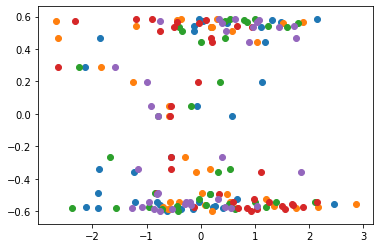

In [1118]:
plt.scatter(X[:, 0], Y.mean(1))
plt.scatter(X[:, 1], Y.mean(1))
plt.scatter(X[:, 2], Y.mean(1))
plt.scatter(X[:, 3], Y.mean(1))
plt.scatter(X[:, 4], Y.mean(1))

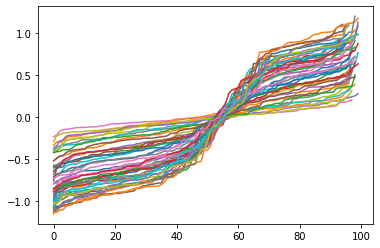

In [1120]:
plt.plot(np.sort(Y, axis=0))
plt.show()

In [1164]:
Xt = torch.tensor(X / np.linalg.norm(X), dtype=torch.float32)
Yt = torch.tensor(Y, dtype=torch.float32)
Winit = torch.distributions.Normal(loc=0.0, scale=1.0).sample((5,))
#Winit = Winit/Winit.abs().sum()
Winit = Winit/torch.norm(Winit)


isnan = torch.isnan(Yt)
Yt[isnan] = 0

isreal = (~isnan).type(torch.float32)

In [1183]:
Xt.clone()

tensor([[ 6.1286e-02,  3.9017e-02,  3.3568e-02,  4.3660e-02, -4.6228e-02],
        [ 2.5142e-02,  3.7865e-02,  2.6980e-02,  1.7046e-02,  5.9843e-02],
        [ 3.1911e-02, -2.0696e-02, -1.0737e-02,  1.5258e-02,  4.0469e-02],
        [ 3.3851e-02,  3.7552e-02, -3.9011e-03,  4.9233e-02,  7.2959e-03],
        [-7.7204e-02,  7.0303e-03,  2.2180e-02, -2.2639e-02, -4.7728e-02],
        [ 4.4608e-02, -7.1316e-03, -1.3537e-02, -7.8152e-03,  2.4687e-02],
        [-7.1892e-03, -4.1855e-03,  2.8799e-02,  9.7971e-02,  9.7519e-02],
        [-7.7855e-02,  6.8053e-04, -3.4864e-02, -3.3408e-02, -3.2092e-02],
        [ 8.7887e-02,  1.2340e-02,  2.1822e-02, -3.6686e-02,  2.6120e-02],
        [-1.4754e-02, -2.3418e-02,  2.5968e-02,  6.3328e-02, -3.5305e-02],
        [ 6.8955e-03,  1.9750e-02,  6.9936e-03,  1.3542e-02, -3.3420e-02],
        [ 5.5398e-02,  3.5573e-02, -2.6981e-02, -2.4588e-02,  2.0895e-02],
        [-4.9416e-02, -1.6496e-02,  4.0887e-02,  2.4108e-02, -3.9515e-02],
        [-2.2652e-02, -1.

In [1165]:
Winit.requires_grad_(True)

tensor([ 0.2360, -0.8896, -0.2484, -0.2617,  0.1506], requires_grad=True)

In [1166]:
Winit.requires_grad

True

In [1167]:
a = torch.tensor(1, dtype=torch.float32, requires_grad=True)
b = torch.tensor(1, dtype=torch.float32, requires_grad=True)

In [1168]:
Yt * isnan

tensor([[-0., -0., -0.,  ..., -0., -0., -0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., -0., 0., 0.],
        [-0., -0., -0.,  ..., -0., -0., -0.]])

In [1155]:
def model():
    for j in neurons:
        # matrix stimuli x roi/recording
        yob = yobs[j]
        # gain or 1
        a = pyro.sample('a{j}', dist.LogNormal(a_mean[j], a_std[j])) # or 1 if linear or no params
        # intrinsic nonlinearity
        inonlin = inonlins[j]
        # intrinsic offset is the same across contexts?
        # or 0
        ioffset = pyro.sample('ioffset{j}', dist.Normal(0, 1)) # or 0 if linear or no params
        # extrinsic nonlinearity
        enonlin = enonlins[j]
        # extrinsice offset can vary across stimulus contexts?
        # or 0 # could be vector for each recording?
        eoffset = pyro.sample('eoffset{j}', dist.Normal(0, 1)) # or 0 if linear or no params
        # indices of input to neuron
        input_idcs = inputs[j]
        # iterate of each input index to get response and weight
        for idx, i in enumerate(input_idcs):
            # get weight for ji connection
            
            # known synaptic count
            if wknown[j, i]:
                wi = pyro.sample(
                    'w{ji}', dist.LogNormal(
                        # transformed or untransformed mu?
                        wmean[j, i], sqrt(wmean[j, i])
                    )
                )
            # unknown synaptic count
            else:
                wi = pyro.sample(
                    'w{ji}', dist.LogNormal(
                        0, large_variance
                    )
                )
            if wsign[j, i] == -1:
                # known vs. unknown
                wi = -wi
            elif wsign[j, i] == 1:
                pass
            else:
                # how certain we are about a sign?
                sign = pyro.sample('sign_w{ji}', dist.Bernoulli(sign_p[ji]))
                if sign == 0:
                    wi = -wi
                
            # response vector (this is assumed a torch.tensor vector)
            xi = pyro.param('x{i}')
            
            if idx == 0:
                x = xi[:, None]
                w = wi[None]
            else:
                # stimuli x input
                x = torch.cat([x, xi[:, None]], axis=1)
                w = torch.cat([w, wi[None]], axis=0)
                
        # normalize w  or use l2-norm? - both works with gradient descent
        w = w / torch.sum(torch.abs(w))
        # normalize each input (x)
        # depends on nonlinearity or not?
        x = x / torch.norm(x) # or not if linear or no gain params?
        # what if an x is consistently higher? - or normalize over all inputs?
        # take frobenius norm
        # predict (stimuli x 1)
        yipred = inonlin(a * (x @ w) - ioffset) + inonlin(ioffset)
        #yipred = inonlin(x @ w, ioffset)
        # sample from latent
        ypred = pyro.sample('x{j}', dist.Normal(yipred, xvar[j]))[:, None]
        # how to choose scale here? - increasing with response?
        # individual offset vs. combined offset?
        # apply extrinsic nonlinearity
        ypred = enonlin(ypred - eoffset) + enonlin(eoffset)
        # imaging response
        yob, ypred = torch.broadcast_tensors(yob, ypred)
        # L1 or L2 normalization? - both work
        ypred_ = ypred * (
            torch.sum(torch.abs(yob) * nonnan, axis=0)[None]
            / torch.sum(torch.abs(ypred) * nonnan, axis=0)[None]
        )
        
        # mask poutine
        pyro.sample(
            'xr{j}', dist.Normal(ypred_, xrvar[j]), obs=yob
            # could use empirical variance or 95% CI!?
        )
        
        

In [1190]:
pyro.param

<function pyro.primitives.param(name, *args, **kwargs)>

In [1169]:
np.nansum(Y ** 2)

1412.641280430425

In [ ]:
torch.

In [1184]:
Xt.ndim

2

In [1179]:
type(dist.Distribution)

abc.ABCMeta

In [1170]:
def tanh(x, r0=0):

    x = np.tanh(x - r0) + np.tanh(r0)

    return x

def ttanh(x, r0=0):
    
    x = torch.tanh(x - r0) + torch.tanh(r0)

    return x
    

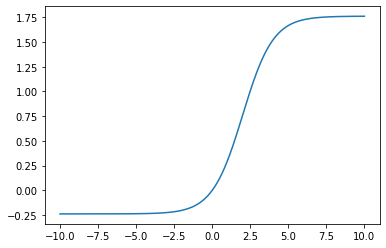

In [1171]:
x = np.linspace(-10, 10, 1001)
plt.plot(x, tanh(0.5*x, 1))

* circuit class with data (with enable/disable vary) - different conditions? - and distribution?
* circuit should also specify distributions, nonlinearities ...
* neuron and synapse can have sign?
* 
* E-M type algorithm: Initialize W and X, fit weights given X, then fit X given weights
* prior on W and prior on X
* normalization step (W vs. X)
* Two types of non-linearities: in circuit or in measurements
    * non-linearity per recording vs for all
* How are synaptic counts distributed (log-normal?)
* We can lack synaptic count data

In [1172]:
losses = []
for i in range(10000):
    
    Winit_ = Winit #/ Winit.abs().sum()
        
    # Y_predict = torch.tanh((Xt @ (Winit/Winit.abs().sum()))[:, None])
    Y_predict = torch.tanh(a * (Xt @ Winit_))[:, None]
    # Y_predict = torch.tanh(Xt @ Winit_)[:, None]
    Y_predict, Yt = torch.broadcast_tensors(Y_predict, Yt)
#     Y_predict = Y_predict / Y_predict.abs().sum(axis=1, keepdims=True)
#     Yt_ = Yt / Yt.abs().sum(axis=1, keepdims=True)

    # Yp = Y_predict #/ torch.sum(torch.abs(Y_predict) * isreal, axis=0)[None]
    Yp = Y_predict * (
        torch.sqrt(torch.sum(torch.abs(Yt)**2 * isreal, axis=0))[None] 
        / torch.sqrt(torch.sum(torch.abs(Y_predict)**2 * isreal, axis=0))[None]
    )
    
#     Y_ = Yt * (
#         torch.sum(torch.abs(Y_predict) * isreal, axis=0)[None] 
#         / torch.sum(torch.abs(Yt) * isreal, axis=0)[None]
#     )
    Y_ = Yt
    
    ll = 0.5 * torch.sum((Yp - Y_)**2)
    
#     ll = - torch.sum(Yt[~isnan] * Y_predict[~isnan]) / (
#         torch.sqrt(torch.sum(Yt[~isnan] ** 2)) * 
#         torch.sqrt(torch.sum(Y_predict[~isnan] ** 2))
#     )
#     ll = 0 
#     for inan, iY in zip(isnan.T, Yt.T):
        
    
#         _ll = - torch.sum(iY[~inan] * Y_predict[~inan]) / (
#             torch.sqrt(torch.sum(iY[~inan] ** 2)) * 
#             torch.sqrt(torch.sum(Y_predict[~inan] ** 2))
#         )
        
#         ll = _ll + ll
#     ll = - 0.5 * (Yt_ - Y_predict).pow(2).sum()
    losses.append(float(ll))
    
    ll.backward()
    
    with torch.no_grad():
        
        Winit -= 0.00001 * Winit.grad
        a -= 0.05 * a.grad
        Winit /= torch.norm(Winit) #Winit.abs().sum()
                
        Winit.grad.zero_()
        a.grad.zero_()
    #ll.backward()

In [1173]:
Winit

tensor([ 0.2380, -0.0747,  0.3955, -0.7904,  0.3956], requires_grad=True)

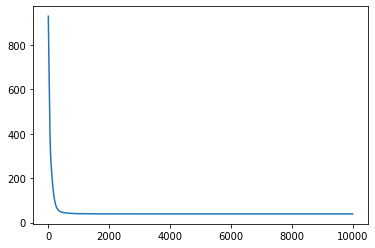

In [1174]:
plt.plot(losses)

In [1175]:
Wpredict = Winit.detach().numpy()
Wpredict / np.sum(np.abs(Wpredict))

array([ 0.12565444, -0.03944741,  0.20879865, -0.4172524 ,  0.2088471 ],
      dtype=float32)

In [1176]:
W[:, 0] / np.sum(np.abs(W[:, 0]))

array([ 0.125     , -0.04166667,  0.20833333, -0.41666667,  0.20833333])

In [1135]:
a

tensor(118.6225, requires_grad=True)

In [1024]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

pyro.set_rng_seed(101)

In [1178]:
pyro.param?

In [1025]:
def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(weight, 0.75))

conditioned_scale = pyro.condition(scale, data={"measurement": 9.5})

def intractable_scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(some_nonlinear_function(weight), 0.75))

def scale_parametrized_guide(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.))
    return pyro.sample("weight", dist.Normal(a, torch.abs(b)))

from torch.distributions import constraints

def scale_parametrized_guide_constrained(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.), constraint=constraints.positive)
    return pyro.sample("weight", dist.Normal(a, b))  

a =  9.107474327087402
b =  0.6285384893417358


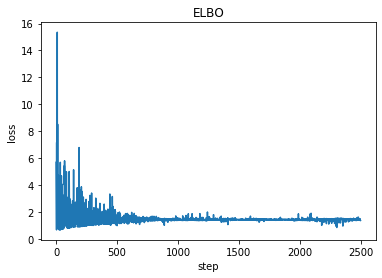

In [1027]:
guess = 8.5

pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale,
                     guide=scale_parametrized_guide,
                     optim=pyro.optim.SGD({"lr": 0.001, "momentum":0.1}),
                     loss=pyro.infer.Trace_ELBO())


losses, a,b  = [], [], []
num_steps = 2500
for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('a = ',pyro.param("a").item())
print('b = ', pyro.param("b").item())

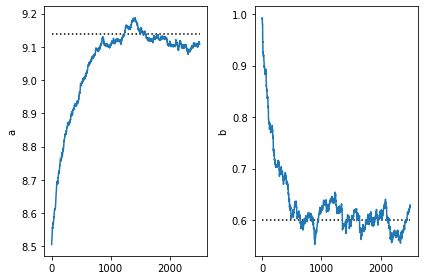

In [1028]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[9.14,9.14], 'k:')
plt.plot(a)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,num_steps],[0.6,0.6], 'k:')
plt.plot(b)
plt.tight_layout()

In [1078]:
pyro.param('a').item

<function Tensor.item>

In [ ]:
pyro.param('a').item

In [1037]:
torch.cat([torch.tensor([1,2,3])[:, None], torch.tensor([1,2,3])[:, None]], axis=1)

tensor([[1, 1],
        [2, 2],
        [3, 3]])